In [28]:
import numpy as np
import pandas as pd
import string
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Obrobka i wczytanie danych#

In [6]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=
		[0, 1], names=['Spam', 'Text'], skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0,
		1])

def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))

stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

stemmer = nltk.PorterStemmer()


def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))

lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))



<ipython-input-6-23d1e0211a72>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0,


#Nauka modelu#

In [11]:
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#dla danych treningowych
count_v2 = CountVectorizer(max_df=0.1, max_features=500)
X_count_v2 = count_v2.fit_transform(X_train)
lda = LatentDirichletAllocation(n_components=7, random_state=2022,
                                learning_method='batch')
X_topics = lda.fit_transform(X_count_v2)

#dla testowych
X_count_v2_test = count_v2.transform(X_test)
X_topics_test = lda.transform(X_count_v2_test)

In [20]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=2022)
model_forest.fit(X_topics, y_train)

RandomForestClassifier(random_state=2022)

In [26]:
print(classification_report(y_train, model_forest.predict(X_topics)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3860
           1       1.00      0.99      1.00       597

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [24]:
print(classification_report(y_test, model_forest.predict(X_topics_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       965
           1       0.93      0.75      0.83       150

    accuracy                           0.96      1115
   macro avg       0.95      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



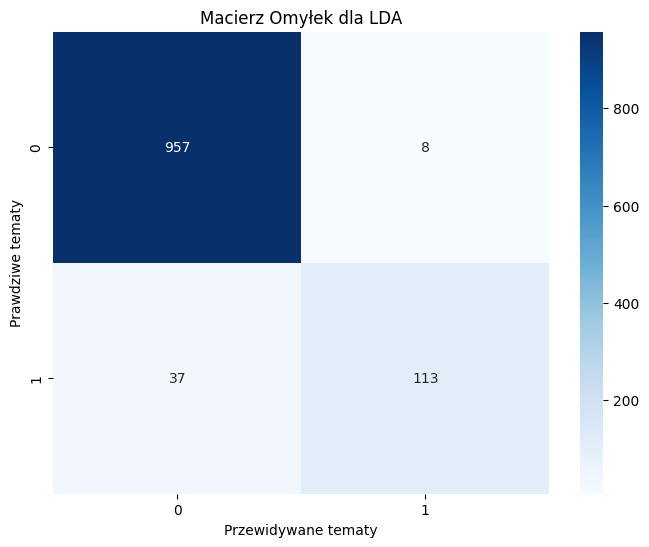

In [30]:
y_pred = model_forest.predict(X_topics_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Przewidywane tematy')
plt.ylabel('Prawdziwe tematy')
plt.title('Macierz Omyłek dla LDA')
plt.show()